In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-08 08:51:44.788405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 08:51:44.788481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/394


2022-05-08 08:51:52.814583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 08:51:52.814628: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 08:51:52.814662: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-08 08:51:52.815015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


39/39 [==============================] - 3s 24ms/step - loss: 0.7213 - accuracy: 0.5001 - auc: 0.4586 - val_loss: 0.7066 - val_accuracy: 0.4961 - val_auc: 0.4554
Epoch 2/394
39/39 [==============================] - 0s 11ms/step - loss: 0.7140 - accuracy: 0.5039 - auc: 0.4750 - val_loss: 0.7016 - val_accuracy: 0.4951 - val_auc: 0.4763
Epoch 3/394
39/39 [==============================] - 0s 12ms/step - loss: 0.7075 - accuracy: 0.5034 - auc: 0.4898 - val_loss: 0.6977 - val_accuracy: 0.4963 - val_auc: 0.4953
Epoch 4/394
39/39 [==============================] - 1s 15ms/step - loss: 0.7064 - accuracy: 0.4971 - auc: 0.4920 - val_loss: 0.6945 - val_accuracy: 0.4986 - val_auc: 0.5124
Epoch 5/394
39/39 [==============================] - 0s 12ms/step - loss: 0.7012 - accuracy: 0.4996 - auc: 0.5113 - val_loss: 0.6919 - val_accuracy: 0.5013 - val_auc: 0.5277
Epoch 6/394
39/39 [==============================] - 1s 15ms/step - loss: 0.6971 - accuracy: 0.5106 - auc: 0.5265 - val_loss: 0.6898 - val_acc

39/39 [==============================] - 0s 8ms/step - loss: 0.6623 - accuracy: 0.5581 - auc: 0.6881 - val_loss: 0.6576 - val_accuracy: 0.5659 - val_auc: 0.7807
Epoch 49/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6619 - accuracy: 0.5565 - auc: 0.6896 - val_loss: 0.6569 - val_accuracy: 0.5680 - val_auc: 0.7842
Epoch 50/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6615 - accuracy: 0.5583 - auc: 0.6932 - val_loss: 0.6563 - val_accuracy: 0.5709 - val_auc: 0.7871
Epoch 51/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6610 - accuracy: 0.5644 - auc: 0.6956 - val_loss: 0.6556 - val_accuracy: 0.5739 - val_auc: 0.7900
Epoch 52/394
39/39 [==============================] - 0s 6ms/step - loss: 0.6613 - accuracy: 0.5617 - auc: 0.6923 - val_loss: 0.6550 - val_accuracy: 0.5783 - val_auc: 0.7929
Epoch 53/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6607 - accuracy: 0.5652 - auc: 0.6940 - val_loss: 0.6543 - val_acc

39/39 [==============================] - 0s 9ms/step - loss: 0.6256 - accuracy: 0.6476 - auc: 0.7655 - val_loss: 0.6126 - val_accuracy: 0.7333 - val_auc: 0.8831
Epoch 96/394
39/39 [==============================] - 0s 11ms/step - loss: 0.6234 - accuracy: 0.6578 - auc: 0.7692 - val_loss: 0.6111 - val_accuracy: 0.7361 - val_auc: 0.8845
Epoch 97/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6229 - accuracy: 0.6551 - auc: 0.7676 - val_loss: 0.6098 - val_accuracy: 0.7418 - val_auc: 0.8862
Epoch 98/394
39/39 [==============================] - 1s 14ms/step - loss: 0.6195 - accuracy: 0.6577 - auc: 0.7759 - val_loss: 0.6082 - val_accuracy: 0.7442 - val_auc: 0.8875
Epoch 99/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6183 - accuracy: 0.6622 - auc: 0.7792 - val_loss: 0.6069 - val_accuracy: 0.7492 - val_auc: 0.8889
Epoch 100/394
39/39 [==============================] - 0s 10ms/step - loss: 0.6183 - accuracy: 0.6662 - auc: 0.7759 - val_loss: 0.6053 - val_

Epoch 142/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5545 - accuracy: 0.7372 - auc: 0.8290 - val_loss: 0.5239 - val_accuracy: 0.8522 - val_auc: 0.9361
Epoch 143/394
39/39 [==============================] - 0s 11ms/step - loss: 0.5534 - accuracy: 0.7351 - auc: 0.8273 - val_loss: 0.5216 - val_accuracy: 0.8534 - val_auc: 0.9368
Epoch 144/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5477 - accuracy: 0.7448 - auc: 0.8330 - val_loss: 0.5192 - val_accuracy: 0.8543 - val_auc: 0.9379
Epoch 145/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5501 - accuracy: 0.7395 - auc: 0.8285 - val_loss: 0.5169 - val_accuracy: 0.8551 - val_auc: 0.9386
Epoch 146/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5485 - accuracy: 0.7418 - auc: 0.8291 - val_loss: 0.5148 - val_accuracy: 0.8565 - val_auc: 0.9395
Epoch 147/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5484 - accuracy: 0.7444 - auc: 0.8295 - val_los

Epoch 189/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4779 - accuracy: 0.7831 - auc: 0.8682 - val_loss: 0.4217 - val_accuracy: 0.8827 - val_auc: 0.9630
Epoch 190/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4750 - accuracy: 0.7814 - auc: 0.8690 - val_loss: 0.4195 - val_accuracy: 0.8832 - val_auc: 0.9633
Epoch 191/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4681 - accuracy: 0.7877 - auc: 0.8763 - val_loss: 0.4170 - val_accuracy: 0.8841 - val_auc: 0.9637
Epoch 192/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4762 - accuracy: 0.7818 - auc: 0.8675 - val_loss: 0.4157 - val_accuracy: 0.8831 - val_auc: 0.9640
Epoch 193/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4769 - accuracy: 0.7802 - auc: 0.8677 - val_loss: 0.4136 - val_accuracy: 0.8840 - val_auc: 0.9643
Epoch 194/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4733 - accuracy: 0.7795 - auc: 0.8696 - val_los

Epoch 236/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4202 - accuracy: 0.8083 - auc: 0.8946 - val_loss: 0.3475 - val_accuracy: 0.8915 - val_auc: 0.9761
Epoch 237/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4187 - accuracy: 0.8073 - auc: 0.8957 - val_loss: 0.3473 - val_accuracy: 0.8895 - val_auc: 0.9763
Epoch 238/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4187 - accuracy: 0.8049 - auc: 0.8950 - val_loss: 0.3476 - val_accuracy: 0.8871 - val_auc: 0.9765
Epoch 239/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4164 - accuracy: 0.8086 - auc: 0.8964 - val_loss: 0.3455 - val_accuracy: 0.8886 - val_auc: 0.9766
Epoch 240/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4183 - accuracy: 0.8084 - auc: 0.8950 - val_loss: 0.3433 - val_accuracy: 0.8911 - val_auc: 0.9768
Epoch 241/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4155 - accuracy: 0.8135 - auc: 0.8961 - val_loss

Epoch 283/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3733 - accuracy: 0.8299 - auc: 0.9161 - val_loss: 0.3030 - val_accuracy: 0.8917 - val_auc: 0.9826
Epoch 284/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3696 - accuracy: 0.8333 - auc: 0.9181 - val_loss: 0.3030 - val_accuracy: 0.8905 - val_auc: 0.9827
Epoch 285/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3720 - accuracy: 0.8303 - auc: 0.9170 - val_loss: 0.3025 - val_accuracy: 0.8902 - val_auc: 0.9829
Epoch 286/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3778 - accuracy: 0.8304 - auc: 0.9126 - val_loss: 0.3019 - val_accuracy: 0.8901 - val_auc: 0.9829
Epoch 287/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3738 - accuracy: 0.8272 - auc: 0.9149 - val_loss: 0.3002 - val_accuracy: 0.8916 - val_auc: 0.9829
Epoch 288/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3741 - accuracy: 0.8326 - auc: 0.9151 - val_loss

Epoch 330/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3412 - accuracy: 0.8451 - auc: 0.9293 - val_loss: 0.2814 - val_accuracy: 0.8845 - val_auc: 0.9855
Epoch 331/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3504 - accuracy: 0.8441 - auc: 0.9245 - val_loss: 0.2807 - val_accuracy: 0.8850 - val_auc: 0.9855
Epoch 332/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3489 - accuracy: 0.8392 - auc: 0.9252 - val_loss: 0.2791 - val_accuracy: 0.8863 - val_auc: 0.9856
Epoch 333/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3491 - accuracy: 0.8395 - auc: 0.9254 - val_loss: 0.2803 - val_accuracy: 0.8849 - val_auc: 0.9856
Epoch 334/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3458 - accuracy: 0.8443 - auc: 0.9265 - val_loss: 0.2787 - val_accuracy: 0.8861 - val_auc: 0.9857
Epoch 335/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3499 - accuracy: 0.8418 - auc: 0.9250 - val_loss

Epoch 377/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3300 - accuracy: 0.8539 - auc: 0.9331 - val_loss: 0.2710 - val_accuracy: 0.8805 - val_auc: 0.9869
Epoch 378/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3230 - accuracy: 0.8559 - auc: 0.9361 - val_loss: 0.2711 - val_accuracy: 0.8801 - val_auc: 0.9870
Epoch 379/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3237 - accuracy: 0.8527 - auc: 0.9359 - val_loss: 0.2691 - val_accuracy: 0.8815 - val_auc: 0.9870
Epoch 380/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3270 - accuracy: 0.8539 - auc: 0.9345 - val_loss: 0.2685 - val_accuracy: 0.8821 - val_auc: 0.9871
Epoch 381/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3253 - accuracy: 0.8483 - auc: 0.9352 - val_loss: 0.2698 - val_accuracy: 0.8803 - val_auc: 0.9871
Epoch 382/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3225 - accuracy: 0.8549 - auc: 0.9362 - val_loss

39/39 [==============================] - 0s 8ms/step - loss: 0.6433 - accuracy: 0.6006 - auc: 0.7502 - val_loss: 0.6378 - val_accuracy: 0.6538 - val_auc: 0.8663
Epoch 29/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6423 - accuracy: 0.6040 - auc: 0.7529 - val_loss: 0.6361 - val_accuracy: 0.6563 - val_auc: 0.8696
Epoch 30/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6410 - accuracy: 0.6071 - auc: 0.7572 - val_loss: 0.6345 - val_accuracy: 0.6622 - val_auc: 0.8724
Epoch 31/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6400 - accuracy: 0.6090 - auc: 0.7514 - val_loss: 0.6333 - val_accuracy: 0.6727 - val_auc: 0.8744
Epoch 32/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6380 - accuracy: 0.6116 - auc: 0.7600 - val_loss: 0.6316 - val_accuracy: 0.6773 - val_auc: 0.8770
Epoch 33/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6381 - accuracy: 0.6143 - auc: 0.7591 - val_loss: 0.6299 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.5593 - accuracy: 0.7356 - auc: 0.8310 - val_loss: 0.5295 - val_accuracy: 0.8597 - val_auc: 0.9413
Epoch 76/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5570 - accuracy: 0.7358 - auc: 0.8328 - val_loss: 0.5261 - val_accuracy: 0.8608 - val_auc: 0.9424
Epoch 77/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5539 - accuracy: 0.7386 - auc: 0.8354 - val_loss: 0.5226 - val_accuracy: 0.8619 - val_auc: 0.9434
Epoch 78/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5536 - accuracy: 0.7371 - auc: 0.8320 - val_loss: 0.5197 - val_accuracy: 0.8636 - val_auc: 0.9444
Epoch 79/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5538 - accuracy: 0.7383 - auc: 0.8324 - val_loss: 0.5173 - val_accuracy: 0.8654 - val_auc: 0.9453
Epoch 80/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5469 - accuracy: 0.7462 - auc: 0.8394 - val_loss: 0.5143 - val_acc

39/39 [==============================] - 0s 6ms/step - loss: 0.4526 - accuracy: 0.7978 - auc: 0.8855 - val_loss: 0.3927 - val_accuracy: 0.8957 - val_auc: 0.9714
Epoch 123/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4553 - accuracy: 0.7959 - auc: 0.8825 - val_loss: 0.3910 - val_accuracy: 0.8951 - val_auc: 0.9718
Epoch 124/394
39/39 [==============================] - 0s 11ms/step - loss: 0.4548 - accuracy: 0.7961 - auc: 0.8835 - val_loss: 0.3893 - val_accuracy: 0.8939 - val_auc: 0.9721
Epoch 125/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4497 - accuracy: 0.8008 - auc: 0.8856 - val_loss: 0.3867 - val_accuracy: 0.8947 - val_auc: 0.9724
Epoch 126/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4510 - accuracy: 0.7969 - auc: 0.8841 - val_loss: 0.3838 - val_accuracy: 0.8961 - val_auc: 0.9729
Epoch 127/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4414 - accuracy: 0.8098 - auc: 0.8929 - val_loss: 0.3819 - v

Epoch 169/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3924 - accuracy: 0.8175 - auc: 0.9070 - val_loss: 0.3110 - val_accuracy: 0.8971 - val_auc: 0.9822
Epoch 170/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3838 - accuracy: 0.8227 - auc: 0.9129 - val_loss: 0.3094 - val_accuracy: 0.8974 - val_auc: 0.9823
Epoch 171/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3851 - accuracy: 0.8269 - auc: 0.9111 - val_loss: 0.3078 - val_accuracy: 0.8982 - val_auc: 0.9825
Epoch 172/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3776 - accuracy: 0.8313 - auc: 0.9168 - val_loss: 0.3068 - val_accuracy: 0.8977 - val_auc: 0.9826
Epoch 173/394
39/39 [==============================] - 0s 11ms/step - loss: 0.3867 - accuracy: 0.8272 - auc: 0.9102 - val_loss: 0.3054 - val_accuracy: 0.8979 - val_auc: 0.9828
Epoch 174/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3784 - accuracy: 0.8273 - auc: 0.9155 - val_los

Epoch 216/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3404 - accuracy: 0.8472 - auc: 0.9306 - val_loss: 0.2744 - val_accuracy: 0.8922 - val_auc: 0.9862
Epoch 217/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3491 - accuracy: 0.8387 - auc: 0.9259 - val_loss: 0.2759 - val_accuracy: 0.8892 - val_auc: 0.9862
Epoch 218/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3420 - accuracy: 0.8479 - auc: 0.9296 - val_loss: 0.2759 - val_accuracy: 0.8888 - val_auc: 0.9863
Epoch 219/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3471 - accuracy: 0.8442 - auc: 0.9262 - val_loss: 0.2735 - val_accuracy: 0.8909 - val_auc: 0.9864
Epoch 220/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3409 - accuracy: 0.8453 - auc: 0.9298 - val_loss: 0.2713 - val_accuracy: 0.8931 - val_auc: 0.9865
Epoch 221/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3427 - accuracy: 0.8481 - auc: 0.9289 - val_loss

Epoch 263/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3244 - accuracy: 0.8530 - auc: 0.9358 - val_loss: 0.2686 - val_accuracy: 0.8791 - val_auc: 0.9878
Epoch 264/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3191 - accuracy: 0.8595 - auc: 0.9384 - val_loss: 0.2685 - val_accuracy: 0.8794 - val_auc: 0.9878
Epoch 265/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3205 - accuracy: 0.8554 - auc: 0.9373 - val_loss: 0.2667 - val_accuracy: 0.8807 - val_auc: 0.9879
Epoch 266/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3184 - accuracy: 0.8553 - auc: 0.9381 - val_loss: 0.2628 - val_accuracy: 0.8839 - val_auc: 0.9879
Epoch 267/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3139 - accuracy: 0.8595 - auc: 0.9402 - val_loss: 0.2640 - val_accuracy: 0.8829 - val_auc: 0.9880
Epoch 268/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3172 - accuracy: 0.8600 - auc: 0.9386 - val_loss

Epoch 310/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3077 - accuracy: 0.8630 - auc: 0.9418 - val_loss: 0.2672 - val_accuracy: 0.8724 - val_auc: 0.9887
Epoch 311/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3041 - accuracy: 0.8659 - auc: 0.9434 - val_loss: 0.2670 - val_accuracy: 0.8725 - val_auc: 0.9886
Epoch 312/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3058 - accuracy: 0.8602 - auc: 0.9432 - val_loss: 0.2701 - val_accuracy: 0.8694 - val_auc: 0.9886
Epoch 313/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3041 - accuracy: 0.8619 - auc: 0.9441 - val_loss: 0.2697 - val_accuracy: 0.8694 - val_auc: 0.9886
Epoch 314/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3054 - accuracy: 0.8639 - auc: 0.9429 - val_loss: 0.2688 - val_accuracy: 0.8701 - val_auc: 0.9886
Epoch 315/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2991 - accuracy: 0.8645 - auc: 0.9455 - val_loss

Epoch 357/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2889 - accuracy: 0.8754 - auc: 0.9492 - val_loss: 0.2780 - val_accuracy: 0.8593 - val_auc: 0.9891
Epoch 358/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2868 - accuracy: 0.8727 - auc: 0.9496 - val_loss: 0.2792 - val_accuracy: 0.8584 - val_auc: 0.9891
Epoch 359/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2916 - accuracy: 0.8675 - auc: 0.9480 - val_loss: 0.2783 - val_accuracy: 0.8591 - val_auc: 0.9891
Epoch 360/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2924 - accuracy: 0.8714 - auc: 0.9475 - val_loss: 0.2781 - val_accuracy: 0.8589 - val_auc: 0.9890
Epoch 361/394
39/39 [==============================] - 0s 9ms/step - loss: 0.2880 - accuracy: 0.8733 - auc: 0.9494 - val_loss: 0.2785 - val_accuracy: 0.8589 - val_auc: 0.9890
Epoch 362/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2890 - accuracy: 0.8729 - auc: 0.9487 - val_lo

39/39 [==============================] - 0s 8ms/step - loss: 0.6793 - accuracy: 0.5165 - auc: 0.6317 - val_loss: 0.6674 - val_accuracy: 0.5110 - val_auc: 0.7870
Epoch 9/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6761 - accuracy: 0.5309 - auc: 0.6399 - val_loss: 0.6657 - val_accuracy: 0.5124 - val_auc: 0.7963
Epoch 10/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6768 - accuracy: 0.5177 - auc: 0.6388 - val_loss: 0.6639 - val_accuracy: 0.5128 - val_auc: 0.8067
Epoch 11/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6732 - accuracy: 0.5324 - auc: 0.6562 - val_loss: 0.6624 - val_accuracy: 0.5146 - val_auc: 0.8135
Epoch 12/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6715 - accuracy: 0.5348 - auc: 0.6587 - val_loss: 0.6609 - val_accuracy: 0.5166 - val_auc: 0.8195
Epoch 13/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6695 - accuracy: 0.5315 - auc: 0.6666 - val_loss: 0.6592 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.5899 - accuracy: 0.7048 - auc: 0.8056 - val_loss: 0.5651 - val_accuracy: 0.7982 - val_auc: 0.9287
Epoch 56/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5864 - accuracy: 0.7031 - auc: 0.8117 - val_loss: 0.5612 - val_accuracy: 0.7997 - val_auc: 0.9304
Epoch 57/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5850 - accuracy: 0.7112 - auc: 0.8099 - val_loss: 0.5575 - val_accuracy: 0.8068 - val_auc: 0.9323
Epoch 58/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5837 - accuracy: 0.7116 - auc: 0.8086 - val_loss: 0.5542 - val_accuracy: 0.8134 - val_auc: 0.9334
Epoch 59/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5793 - accuracy: 0.7138 - auc: 0.8155 - val_loss: 0.5504 - val_accuracy: 0.8170 - val_auc: 0.9348
Epoch 60/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5756 - accuracy: 0.7219 - auc: 0.8192 - val_loss: 0.5469 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.4590 - accuracy: 0.7918 - auc: 0.8787 - val_loss: 0.3876 - val_accuracy: 0.9010 - val_auc: 0.9725
Epoch 103/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4542 - accuracy: 0.7940 - auc: 0.8813 - val_loss: 0.3845 - val_accuracy: 0.9019 - val_auc: 0.9730
Epoch 104/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4539 - accuracy: 0.7928 - auc: 0.8818 - val_loss: 0.3811 - val_accuracy: 0.9028 - val_auc: 0.9734
Epoch 105/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4526 - accuracy: 0.7941 - auc: 0.8814 - val_loss: 0.3791 - val_accuracy: 0.9029 - val_auc: 0.9737
Epoch 106/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4466 - accuracy: 0.8001 - auc: 0.8861 - val_loss: 0.3757 - val_accuracy: 0.9029 - val_auc: 0.9741
Epoch 107/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4447 - accuracy: 0.7991 - auc: 0.8867 - val_loss: 0.3728 - va

Epoch 149/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3814 - accuracy: 0.8226 - auc: 0.9119 - val_loss: 0.2894 - val_accuracy: 0.9081 - val_auc: 0.9846
Epoch 150/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3708 - accuracy: 0.8307 - auc: 0.9179 - val_loss: 0.2892 - val_accuracy: 0.9064 - val_auc: 0.9847
Epoch 151/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3749 - accuracy: 0.8312 - auc: 0.9154 - val_loss: 0.2883 - val_accuracy: 0.9062 - val_auc: 0.9848
Epoch 152/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3730 - accuracy: 0.8291 - auc: 0.9157 - val_loss: 0.2878 - val_accuracy: 0.9053 - val_auc: 0.9849
Epoch 153/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3692 - accuracy: 0.8325 - auc: 0.9184 - val_loss: 0.2887 - val_accuracy: 0.9027 - val_auc: 0.9850
Epoch 154/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3674 - accuracy: 0.8329 - auc: 0.9188 - val_loss

Epoch 196/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3355 - accuracy: 0.8492 - auc: 0.9310 - val_loss: 0.2558 - val_accuracy: 0.9013 - val_auc: 0.9874
Epoch 197/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3408 - accuracy: 0.8476 - auc: 0.9286 - val_loss: 0.2567 - val_accuracy: 0.9002 - val_auc: 0.9874
Epoch 198/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3301 - accuracy: 0.8547 - auc: 0.9336 - val_loss: 0.2567 - val_accuracy: 0.8996 - val_auc: 0.9876
Epoch 199/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3338 - accuracy: 0.8486 - auc: 0.9322 - val_loss: 0.2560 - val_accuracy: 0.8999 - val_auc: 0.9876
Epoch 200/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3287 - accuracy: 0.8555 - auc: 0.9342 - val_loss: 0.2566 - val_accuracy: 0.8985 - val_auc: 0.9876
Epoch 201/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3230 - accuracy: 0.8558 - auc: 0.9372 - val_los

Epoch 243/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3132 - accuracy: 0.8598 - auc: 0.9397 - val_loss: 0.2550 - val_accuracy: 0.8856 - val_auc: 0.9883
Epoch 244/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3110 - accuracy: 0.8602 - auc: 0.9404 - val_loss: 0.2554 - val_accuracy: 0.8848 - val_auc: 0.9882
Epoch 245/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3134 - accuracy: 0.8620 - auc: 0.9396 - val_loss: 0.2573 - val_accuracy: 0.8833 - val_auc: 0.9882
Epoch 246/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3106 - accuracy: 0.8579 - auc: 0.9410 - val_loss: 0.2579 - val_accuracy: 0.8827 - val_auc: 0.9882
Epoch 247/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3087 - accuracy: 0.8609 - auc: 0.9418 - val_loss: 0.2546 - val_accuracy: 0.8851 - val_auc: 0.9883
Epoch 248/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3141 - accuracy: 0.8563 - auc: 0.9393 - val_loss

Epoch 290/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2889 - accuracy: 0.8747 - auc: 0.9491 - val_loss: 0.2562 - val_accuracy: 0.8789 - val_auc: 0.9887
Epoch 291/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2930 - accuracy: 0.8699 - auc: 0.9473 - val_loss: 0.2559 - val_accuracy: 0.8792 - val_auc: 0.9887
Epoch 292/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2964 - accuracy: 0.8685 - auc: 0.9461 - val_loss: 0.2535 - val_accuracy: 0.8809 - val_auc: 0.9887
Epoch 293/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2912 - accuracy: 0.8698 - auc: 0.9484 - val_loss: 0.2562 - val_accuracy: 0.8788 - val_auc: 0.9887
Epoch 294/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2885 - accuracy: 0.8734 - auc: 0.9491 - val_loss: 0.2540 - val_accuracy: 0.8805 - val_auc: 0.9887
Epoch 295/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2932 - accuracy: 0.8650 - auc: 0.9471 - val_loss

Epoch 337/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2772 - accuracy: 0.8796 - auc: 0.9528 - val_loss: 0.2667 - val_accuracy: 0.8700 - val_auc: 0.9889
Epoch 338/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2846 - accuracy: 0.8714 - auc: 0.9503 - val_loss: 0.2639 - val_accuracy: 0.8719 - val_auc: 0.9889
Epoch 339/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2780 - accuracy: 0.8789 - auc: 0.9526 - val_loss: 0.2660 - val_accuracy: 0.8702 - val_auc: 0.9889
Epoch 340/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2850 - accuracy: 0.8765 - auc: 0.9500 - val_loss: 0.2608 - val_accuracy: 0.8737 - val_auc: 0.9890
Epoch 341/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2816 - accuracy: 0.8728 - auc: 0.9520 - val_loss: 0.2619 - val_accuracy: 0.8731 - val_auc: 0.9889
Epoch 342/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2748 - accuracy: 0.8797 - auc: 0.9538 - val_loss

Epoch 384/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2750 - accuracy: 0.8768 - auc: 0.9537 - val_loss: 0.2821 - val_accuracy: 0.8575 - val_auc: 0.9891
Epoch 385/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2671 - accuracy: 0.8804 - auc: 0.9564 - val_loss: 0.2796 - val_accuracy: 0.8593 - val_auc: 0.9891
Epoch 386/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2655 - accuracy: 0.8803 - auc: 0.9572 - val_loss: 0.2808 - val_accuracy: 0.8586 - val_auc: 0.9891
Epoch 387/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2664 - accuracy: 0.8833 - auc: 0.9565 - val_loss: 0.2779 - val_accuracy: 0.8606 - val_auc: 0.9891
Epoch 388/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2717 - accuracy: 0.8784 - auc: 0.9547 - val_loss: 0.2740 - val_accuracy: 0.8627 - val_auc: 0.9891
Epoch 389/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2638 - accuracy: 0.8860 - auc: 0.9572 - val_loss

39/39 [==============================] - 0s 7ms/step - loss: 0.6681 - accuracy: 0.5709 - auc: 0.6500 - val_loss: 0.6619 - val_accuracy: 0.6087 - val_auc: 0.7458
Epoch 36/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6679 - accuracy: 0.5750 - auc: 0.6489 - val_loss: 0.6611 - val_accuracy: 0.6133 - val_auc: 0.7486
Epoch 37/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6666 - accuracy: 0.5726 - auc: 0.6556 - val_loss: 0.6603 - val_accuracy: 0.6180 - val_auc: 0.7514
Epoch 38/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6665 - accuracy: 0.5750 - auc: 0.6518 - val_loss: 0.6595 - val_accuracy: 0.6221 - val_auc: 0.7542
Epoch 39/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6669 - accuracy: 0.5782 - auc: 0.6521 - val_loss: 0.6587 - val_accuracy: 0.6288 - val_auc: 0.7568
Epoch 40/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6642 - accuracy: 0.5875 - auc: 0.6636 - val_loss: 0.6579 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.6305 - accuracy: 0.6569 - auc: 0.7352 - val_loss: 0.6228 - val_accuracy: 0.7494 - val_auc: 0.8328
Epoch 83/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6262 - accuracy: 0.6677 - auc: 0.7461 - val_loss: 0.6217 - val_accuracy: 0.7510 - val_auc: 0.8340
Epoch 84/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6279 - accuracy: 0.6652 - auc: 0.7420 - val_loss: 0.6209 - val_accuracy: 0.7528 - val_auc: 0.8354
Epoch 85/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6275 - accuracy: 0.6622 - auc: 0.7415 - val_loss: 0.6199 - val_accuracy: 0.7539 - val_auc: 0.8368
Epoch 86/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6260 - accuracy: 0.6704 - auc: 0.7465 - val_loss: 0.6190 - val_accuracy: 0.7553 - val_auc: 0.8380
Epoch 87/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6248 - accuracy: 0.6696 - auc: 0.7474 - val_loss: 0.6181 - val_accu

Epoch 129/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5883 - accuracy: 0.7173 - auc: 0.7915 - val_loss: 0.5732 - val_accuracy: 0.7951 - val_auc: 0.8871
Epoch 130/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5828 - accuracy: 0.7190 - auc: 0.7981 - val_loss: 0.5720 - val_accuracy: 0.7958 - val_auc: 0.8882
Epoch 131/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5818 - accuracy: 0.7128 - auc: 0.7973 - val_loss: 0.5708 - val_accuracy: 0.7963 - val_auc: 0.8894
Epoch 132/828
39/39 [==============================] - 0s 13ms/step - loss: 0.5814 - accuracy: 0.7239 - auc: 0.8005 - val_loss: 0.5694 - val_accuracy: 0.7965 - val_auc: 0.8905
Epoch 133/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5792 - accuracy: 0.7234 - auc: 0.8023 - val_loss: 0.5681 - val_accuracy: 0.7968 - val_auc: 0.8915
Epoch 134/828
39/39 [==============================] - 1s 14ms/step - loss: 0.5783 - accuracy: 0.7242 - auc: 0.8015 - val_l

Epoch 176/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5306 - accuracy: 0.7495 - auc: 0.8382 - val_loss: 0.5086 - val_accuracy: 0.8271 - val_auc: 0.9299
Epoch 177/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5353 - accuracy: 0.7441 - auc: 0.8315 - val_loss: 0.5076 - val_accuracy: 0.8274 - val_auc: 0.9306
Epoch 178/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5301 - accuracy: 0.7567 - auc: 0.8390 - val_loss: 0.5059 - val_accuracy: 0.8281 - val_auc: 0.9314
Epoch 179/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5315 - accuracy: 0.7525 - auc: 0.8370 - val_loss: 0.5044 - val_accuracy: 0.8292 - val_auc: 0.9323
Epoch 180/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5232 - accuracy: 0.7613 - auc: 0.8462 - val_loss: 0.5031 - val_accuracy: 0.8291 - val_auc: 0.9330
Epoch 181/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5272 - accuracy: 0.7580 - auc: 0.8391 - val_los

Epoch 223/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4716 - accuracy: 0.7880 - auc: 0.8763 - val_loss: 0.4361 - val_accuracy: 0.8562 - val_auc: 0.9596
Epoch 224/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4717 - accuracy: 0.7834 - auc: 0.8753 - val_loss: 0.4345 - val_accuracy: 0.8569 - val_auc: 0.9601
Epoch 225/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4734 - accuracy: 0.7882 - auc: 0.8736 - val_loss: 0.4334 - val_accuracy: 0.8562 - val_auc: 0.9604
Epoch 226/828
39/39 [==============================] - 1s 14ms/step - loss: 0.4724 - accuracy: 0.7883 - auc: 0.8737 - val_loss: 0.4317 - val_accuracy: 0.8571 - val_auc: 0.9610
Epoch 227/828
39/39 [==============================] - 0s 10ms/step - loss: 0.4689 - accuracy: 0.7875 - auc: 0.8756 - val_loss: 0.4306 - val_accuracy: 0.8565 - val_auc: 0.9614
Epoch 228/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4675 - accuracy: 0.7871 - auc: 0.8766 - val_

Epoch 270/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4197 - accuracy: 0.8106 - auc: 0.8999 - val_loss: 0.3676 - val_accuracy: 0.8794 - val_auc: 0.9765
Epoch 271/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4209 - accuracy: 0.8134 - auc: 0.8999 - val_loss: 0.3656 - val_accuracy: 0.8810 - val_auc: 0.9767
Epoch 272/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4219 - accuracy: 0.8120 - auc: 0.8965 - val_loss: 0.3647 - val_accuracy: 0.8809 - val_auc: 0.9770
Epoch 273/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4166 - accuracy: 0.8176 - auc: 0.9022 - val_loss: 0.3630 - val_accuracy: 0.8813 - val_auc: 0.9773
Epoch 274/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4194 - accuracy: 0.8121 - auc: 0.8999 - val_loss: 0.3618 - val_accuracy: 0.8814 - val_auc: 0.9775
Epoch 275/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4184 - accuracy: 0.8138 - auc: 0.9005 - val_los

Epoch 317/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3753 - accuracy: 0.8320 - auc: 0.9195 - val_loss: 0.3164 - val_accuracy: 0.8906 - val_auc: 0.9842
Epoch 318/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3813 - accuracy: 0.8297 - auc: 0.9158 - val_loss: 0.3151 - val_accuracy: 0.8911 - val_auc: 0.9843
Epoch 319/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3783 - accuracy: 0.8356 - auc: 0.9174 - val_loss: 0.3140 - val_accuracy: 0.8914 - val_auc: 0.9844
Epoch 320/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3706 - accuracy: 0.8353 - auc: 0.9226 - val_loss: 0.3128 - val_accuracy: 0.8921 - val_auc: 0.9845
Epoch 321/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3773 - accuracy: 0.8343 - auc: 0.9181 - val_loss: 0.3125 - val_accuracy: 0.8913 - val_auc: 0.9845
Epoch 322/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3763 - accuracy: 0.8320 - auc: 0.9174 - val_los

Epoch 364/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3616 - accuracy: 0.8371 - auc: 0.9223 - val_loss: 0.2835 - val_accuracy: 0.8938 - val_auc: 0.9867
Epoch 365/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3467 - accuracy: 0.8476 - auc: 0.9310 - val_loss: 0.2824 - val_accuracy: 0.8944 - val_auc: 0.9867
Epoch 366/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3496 - accuracy: 0.8432 - auc: 0.9289 - val_loss: 0.2813 - val_accuracy: 0.8952 - val_auc: 0.9868
Epoch 367/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3474 - accuracy: 0.8451 - auc: 0.9294 - val_loss: 0.2822 - val_accuracy: 0.8931 - val_auc: 0.9869
Epoch 368/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3535 - accuracy: 0.8435 - auc: 0.9263 - val_loss: 0.2817 - val_accuracy: 0.8928 - val_auc: 0.9868
Epoch 369/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3441 - accuracy: 0.8459 - auc: 0.9315 - val_los

Epoch 411/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3288 - accuracy: 0.8540 - auc: 0.9372 - val_loss: 0.2636 - val_accuracy: 0.8944 - val_auc: 0.9878
Epoch 412/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3281 - accuracy: 0.8550 - auc: 0.9370 - val_loss: 0.2636 - val_accuracy: 0.8943 - val_auc: 0.9879
Epoch 413/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3364 - accuracy: 0.8506 - auc: 0.9332 - val_loss: 0.2637 - val_accuracy: 0.8936 - val_auc: 0.9879
Epoch 414/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3289 - accuracy: 0.8541 - auc: 0.9364 - val_loss: 0.2587 - val_accuracy: 0.8989 - val_auc: 0.9880
Epoch 415/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3294 - accuracy: 0.8540 - auc: 0.9357 - val_loss: 0.2585 - val_accuracy: 0.8989 - val_auc: 0.9880
Epoch 416/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3309 - accuracy: 0.8544 - auc: 0.9353 - val_lo

Epoch 458/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3205 - accuracy: 0.8572 - auc: 0.9394 - val_loss: 0.2504 - val_accuracy: 0.8955 - val_auc: 0.9885
Epoch 459/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3193 - accuracy: 0.8608 - auc: 0.9391 - val_loss: 0.2497 - val_accuracy: 0.8957 - val_auc: 0.9885
Epoch 460/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3201 - accuracy: 0.8599 - auc: 0.9393 - val_loss: 0.2489 - val_accuracy: 0.8964 - val_auc: 0.9885
Epoch 461/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3150 - accuracy: 0.8626 - auc: 0.9406 - val_loss: 0.2488 - val_accuracy: 0.8962 - val_auc: 0.9886
Epoch 462/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3157 - accuracy: 0.8598 - auc: 0.9407 - val_loss: 0.2486 - val_accuracy: 0.8967 - val_auc: 0.9885
Epoch 463/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3130 - accuracy: 0.8642 - auc: 0.9419 - val_lo

Epoch 505/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3011 - accuracy: 0.8661 - auc: 0.9466 - val_loss: 0.2441 - val_accuracy: 0.8945 - val_auc: 0.9888
Epoch 506/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3106 - accuracy: 0.8614 - auc: 0.9419 - val_loss: 0.2456 - val_accuracy: 0.8932 - val_auc: 0.9888
Epoch 507/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3123 - accuracy: 0.8626 - auc: 0.9417 - val_loss: 0.2449 - val_accuracy: 0.8938 - val_auc: 0.9889
Epoch 508/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2978 - accuracy: 0.8672 - auc: 0.9481 - val_loss: 0.2427 - val_accuracy: 0.8954 - val_auc: 0.9889
Epoch 509/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3007 - accuracy: 0.8722 - auc: 0.9461 - val_loss: 0.2422 - val_accuracy: 0.8959 - val_auc: 0.9890
Epoch 510/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3059 - accuracy: 0.8677 - auc: 0.9444 - val_loss

Epoch 552/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2981 - accuracy: 0.8659 - auc: 0.9466 - val_loss: 0.2389 - val_accuracy: 0.8949 - val_auc: 0.9892
Epoch 553/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2877 - accuracy: 0.8710 - auc: 0.9513 - val_loss: 0.2378 - val_accuracy: 0.8960 - val_auc: 0.9892
Epoch 554/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2973 - accuracy: 0.8666 - auc: 0.9478 - val_loss: 0.2374 - val_accuracy: 0.8959 - val_auc: 0.9892
Epoch 555/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3001 - accuracy: 0.8673 - auc: 0.9471 - val_loss: 0.2381 - val_accuracy: 0.8949 - val_auc: 0.9892
Epoch 556/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2953 - accuracy: 0.8699 - auc: 0.9483 - val_loss: 0.2383 - val_accuracy: 0.8946 - val_auc: 0.9892
Epoch 557/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2937 - accuracy: 0.8719 - auc: 0.9486 - val_los

Epoch 599/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2879 - accuracy: 0.8729 - auc: 0.9508 - val_loss: 0.2390 - val_accuracy: 0.8923 - val_auc: 0.9894
Epoch 600/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2879 - accuracy: 0.8715 - auc: 0.9506 - val_loss: 0.2350 - val_accuracy: 0.8955 - val_auc: 0.9893
Epoch 601/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2840 - accuracy: 0.8759 - auc: 0.9520 - val_loss: 0.2355 - val_accuracy: 0.8947 - val_auc: 0.9892
Epoch 602/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2963 - accuracy: 0.8695 - auc: 0.9478 - val_loss: 0.2339 - val_accuracy: 0.8962 - val_auc: 0.9893
Epoch 603/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2900 - accuracy: 0.8735 - auc: 0.9497 - val_loss: 0.2393 - val_accuracy: 0.8924 - val_auc: 0.9892
Epoch 604/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2837 - accuracy: 0.8751 - auc: 0.9521 - val_los

Epoch 646/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2776 - accuracy: 0.8796 - auc: 0.9542 - val_loss: 0.2317 - val_accuracy: 0.8954 - val_auc: 0.9893
Epoch 647/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2785 - accuracy: 0.8793 - auc: 0.9541 - val_loss: 0.2304 - val_accuracy: 0.8970 - val_auc: 0.9893
Epoch 648/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2809 - accuracy: 0.8790 - auc: 0.9529 - val_loss: 0.2353 - val_accuracy: 0.8928 - val_auc: 0.9892
Epoch 649/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2773 - accuracy: 0.8762 - auc: 0.9542 - val_loss: 0.2329 - val_accuracy: 0.8942 - val_auc: 0.9892
Epoch 650/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2789 - accuracy: 0.8777 - auc: 0.9534 - val_loss: 0.2339 - val_accuracy: 0.8939 - val_auc: 0.9892
Epoch 651/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2786 - accuracy: 0.8801 - auc: 0.9542 - val_lo

Epoch 693/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2752 - accuracy: 0.8776 - auc: 0.9552 - val_loss: 0.2350 - val_accuracy: 0.8911 - val_auc: 0.9893
Epoch 694/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2746 - accuracy: 0.8801 - auc: 0.9552 - val_loss: 0.2336 - val_accuracy: 0.8925 - val_auc: 0.9893
Epoch 695/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2754 - accuracy: 0.8793 - auc: 0.9547 - val_loss: 0.2354 - val_accuracy: 0.8910 - val_auc: 0.9893
Epoch 696/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2737 - accuracy: 0.8799 - auc: 0.9559 - val_loss: 0.2333 - val_accuracy: 0.8925 - val_auc: 0.9893
Epoch 697/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2738 - accuracy: 0.8829 - auc: 0.9552 - val_loss: 0.2343 - val_accuracy: 0.8917 - val_auc: 0.9893
Epoch 698/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2757 - accuracy: 0.8814 - auc: 0.9547 - val_loss

Epoch 740/828
39/39 [==============================] - 1s 14ms/step - loss: 0.2765 - accuracy: 0.8781 - auc: 0.9540 - val_loss: 0.2325 - val_accuracy: 0.8920 - val_auc: 0.9895
Epoch 741/828
39/39 [==============================] - 1s 13ms/step - loss: 0.2691 - accuracy: 0.8835 - auc: 0.9571 - val_loss: 0.2332 - val_accuracy: 0.8910 - val_auc: 0.9895
Epoch 742/828
39/39 [==============================] - 1s 13ms/step - loss: 0.2654 - accuracy: 0.8904 - auc: 0.9585 - val_loss: 0.2362 - val_accuracy: 0.8885 - val_auc: 0.9895
Epoch 743/828
39/39 [==============================] - 0s 10ms/step - loss: 0.2619 - accuracy: 0.8873 - auc: 0.9599 - val_loss: 0.2355 - val_accuracy: 0.8893 - val_auc: 0.9895
Epoch 744/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2681 - accuracy: 0.8855 - auc: 0.9575 - val_loss: 0.2329 - val_accuracy: 0.8913 - val_auc: 0.9895
Epoch 745/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2687 - accuracy: 0.8875 - auc: 0.9568 - val_

Epoch 787/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2640 - accuracy: 0.8875 - auc: 0.9584 - val_loss: 0.2401 - val_accuracy: 0.8863 - val_auc: 0.9894
Epoch 788/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2607 - accuracy: 0.8863 - auc: 0.9588 - val_loss: 0.2377 - val_accuracy: 0.8878 - val_auc: 0.9895
Epoch 789/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2636 - accuracy: 0.8859 - auc: 0.9587 - val_loss: 0.2354 - val_accuracy: 0.8891 - val_auc: 0.9895
Epoch 790/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2577 - accuracy: 0.8902 - auc: 0.9606 - val_loss: 0.2371 - val_accuracy: 0.8881 - val_auc: 0.9895
Epoch 791/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2706 - accuracy: 0.8853 - auc: 0.9558 - val_loss: 0.2347 - val_accuracy: 0.8894 - val_auc: 0.9896
Epoch 792/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2581 - accuracy: 0.8895 - auc: 0.9605 - val_loss

39/39 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.4886 - auc: 0.5089 - val_loss: 0.6921 - val_accuracy: 0.4907 - val_auc: 0.5387
Epoch 5/828
39/39 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.4913 - auc: 0.5216 - val_loss: 0.6888 - val_accuracy: 0.4984 - val_auc: 0.5630
Epoch 6/828
39/39 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.5000 - auc: 0.5404 - val_loss: 0.6862 - val_accuracy: 0.5027 - val_auc: 0.5825
Epoch 7/828
39/39 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5010 - auc: 0.5536 - val_loss: 0.6839 - val_accuracy: 0.5069 - val_auc: 0.6000
Epoch 8/828
39/39 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5049 - auc: 0.5605 - val_loss: 0.6818 - val_accuracy: 0.5107 - val_auc: 0.6161
Epoch 9/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.5126 - auc: 0.5702 - val_loss: 0.6800 - val_accuracy:

39/39 [==============================] - 0s 6ms/step - loss: 0.6281 - accuracy: 0.6626 - auc: 0.7545 - val_loss: 0.6226 - val_accuracy: 0.7813 - val_auc: 0.8762
Epoch 52/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6251 - accuracy: 0.6781 - auc: 0.7657 - val_loss: 0.6211 - val_accuracy: 0.7843 - val_auc: 0.8788
Epoch 53/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6252 - accuracy: 0.6714 - auc: 0.7584 - val_loss: 0.6197 - val_accuracy: 0.7869 - val_auc: 0.8808
Epoch 54/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6226 - accuracy: 0.6797 - auc: 0.7670 - val_loss: 0.6182 - val_accuracy: 0.7894 - val_auc: 0.8830
Epoch 55/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6243 - accuracy: 0.6746 - auc: 0.7605 - val_loss: 0.6170 - val_accuracy: 0.7939 - val_auc: 0.8848
Epoch 56/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6199 - accuracy: 0.6763 - auc: 0.7698 - val_loss: 0.6155 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.5582 - accuracy: 0.7466 - auc: 0.8317 - val_loss: 0.5490 - val_accuracy: 0.8371 - val_auc: 0.9313
Epoch 99/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5589 - accuracy: 0.7395 - auc: 0.8278 - val_loss: 0.5473 - val_accuracy: 0.8368 - val_auc: 0.9319
Epoch 100/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5585 - accuracy: 0.7395 - auc: 0.8276 - val_loss: 0.5457 - val_accuracy: 0.8375 - val_auc: 0.9325
Epoch 101/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5594 - accuracy: 0.7409 - auc: 0.8233 - val_loss: 0.5439 - val_accuracy: 0.8375 - val_auc: 0.9332
Epoch 102/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5538 - accuracy: 0.7451 - auc: 0.8306 - val_loss: 0.5420 - val_accuracy: 0.8378 - val_auc: 0.9337
Epoch 103/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5568 - accuracy: 0.7425 - auc: 0.8272 - val_loss: 0.5405 - val_

Epoch 145/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4911 - accuracy: 0.7785 - auc: 0.8670 - val_loss: 0.4640 - val_accuracy: 0.8516 - val_auc: 0.9561
Epoch 146/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4897 - accuracy: 0.7819 - auc: 0.8676 - val_loss: 0.4624 - val_accuracy: 0.8516 - val_auc: 0.9566
Epoch 147/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4921 - accuracy: 0.7785 - auc: 0.8638 - val_loss: 0.4606 - val_accuracy: 0.8523 - val_auc: 0.9570
Epoch 148/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4851 - accuracy: 0.7848 - auc: 0.8711 - val_loss: 0.4581 - val_accuracy: 0.8540 - val_auc: 0.9574
Epoch 149/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4875 - accuracy: 0.7802 - auc: 0.8672 - val_loss: 0.4566 - val_accuracy: 0.8540 - val_auc: 0.9579
Epoch 150/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4840 - accuracy: 0.7837 - auc: 0.8688 - val_lo

Epoch 192/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4246 - accuracy: 0.8124 - auc: 0.9005 - val_loss: 0.3812 - val_accuracy: 0.8743 - val_auc: 0.9753
Epoch 193/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4266 - accuracy: 0.8094 - auc: 0.8977 - val_loss: 0.3799 - val_accuracy: 0.8745 - val_auc: 0.9756
Epoch 194/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4267 - accuracy: 0.8114 - auc: 0.8974 - val_loss: 0.3805 - val_accuracy: 0.8713 - val_auc: 0.9758
Epoch 195/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4276 - accuracy: 0.8058 - auc: 0.8957 - val_loss: 0.3789 - val_accuracy: 0.8723 - val_auc: 0.9761
Epoch 196/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4251 - accuracy: 0.8096 - auc: 0.8972 - val_loss: 0.3769 - val_accuracy: 0.8734 - val_auc: 0.9764
Epoch 197/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4269 - accuracy: 0.8098 - auc: 0.8964 - val_los

Epoch 239/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3789 - accuracy: 0.8299 - auc: 0.9172 - val_loss: 0.3204 - val_accuracy: 0.8867 - val_auc: 0.9847
Epoch 240/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3821 - accuracy: 0.8273 - auc: 0.9164 - val_loss: 0.3177 - val_accuracy: 0.8894 - val_auc: 0.9849
Epoch 241/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3801 - accuracy: 0.8294 - auc: 0.9164 - val_loss: 0.3175 - val_accuracy: 0.8885 - val_auc: 0.9849
Epoch 242/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3797 - accuracy: 0.8323 - auc: 0.9173 - val_loss: 0.3154 - val_accuracy: 0.8898 - val_auc: 0.9851
Epoch 243/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3711 - accuracy: 0.8343 - auc: 0.9211 - val_loss: 0.3143 - val_accuracy: 0.8899 - val_auc: 0.9852
Epoch 244/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3807 - accuracy: 0.8290 - auc: 0.9157 - val_los

Epoch 286/828
39/39 [==============================] - 1s 14ms/step - loss: 0.3494 - accuracy: 0.8455 - auc: 0.9288 - val_loss: 0.2786 - val_accuracy: 0.8972 - val_auc: 0.9877
Epoch 287/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3498 - accuracy: 0.8418 - auc: 0.9278 - val_loss: 0.2821 - val_accuracy: 0.8913 - val_auc: 0.9877
Epoch 288/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3437 - accuracy: 0.8469 - auc: 0.9311 - val_loss: 0.2779 - val_accuracy: 0.8965 - val_auc: 0.9878
Epoch 289/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3434 - accuracy: 0.8495 - auc: 0.9317 - val_loss: 0.2790 - val_accuracy: 0.8942 - val_auc: 0.9878
Epoch 290/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3384 - accuracy: 0.8487 - auc: 0.9332 - val_loss: 0.2783 - val_accuracy: 0.8946 - val_auc: 0.9878
Epoch 291/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3447 - accuracy: 0.8485 - auc: 0.9307 - val_l

Epoch 333/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3232 - accuracy: 0.8576 - auc: 0.9389 - val_loss: 0.2547 - val_accuracy: 0.9008 - val_auc: 0.9886
Epoch 334/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3213 - accuracy: 0.8592 - auc: 0.9390 - val_loss: 0.2563 - val_accuracy: 0.8989 - val_auc: 0.9886
Epoch 335/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3245 - accuracy: 0.8583 - auc: 0.9385 - val_loss: 0.2559 - val_accuracy: 0.8990 - val_auc: 0.9886
Epoch 336/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3235 - accuracy: 0.8526 - auc: 0.9383 - val_loss: 0.2566 - val_accuracy: 0.8978 - val_auc: 0.9886
Epoch 337/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3180 - accuracy: 0.8604 - auc: 0.9404 - val_loss: 0.2568 - val_accuracy: 0.8972 - val_auc: 0.9885
Epoch 338/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3238 - accuracy: 0.8566 - auc: 0.9392 - val_l

Epoch 380/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3136 - accuracy: 0.8597 - auc: 0.9412 - val_loss: 0.2492 - val_accuracy: 0.8931 - val_auc: 0.9892
Epoch 381/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3059 - accuracy: 0.8660 - auc: 0.9451 - val_loss: 0.2473 - val_accuracy: 0.8954 - val_auc: 0.9892
Epoch 382/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3008 - accuracy: 0.8673 - auc: 0.9470 - val_loss: 0.2442 - val_accuracy: 0.8982 - val_auc: 0.9893
Epoch 383/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3074 - accuracy: 0.8662 - auc: 0.9443 - val_loss: 0.2489 - val_accuracy: 0.8931 - val_auc: 0.9892
Epoch 384/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3093 - accuracy: 0.8648 - auc: 0.9441 - val_loss: 0.2458 - val_accuracy: 0.8959 - val_auc: 0.9892
Epoch 385/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3024 - accuracy: 0.8698 - auc: 0.9471 - val_los

Epoch 427/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2902 - accuracy: 0.8736 - auc: 0.9511 - val_loss: 0.2402 - val_accuracy: 0.8953 - val_auc: 0.9896
Epoch 428/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2986 - accuracy: 0.8664 - auc: 0.9472 - val_loss: 0.2400 - val_accuracy: 0.8954 - val_auc: 0.9895
Epoch 429/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3006 - accuracy: 0.8707 - auc: 0.9459 - val_loss: 0.2414 - val_accuracy: 0.8941 - val_auc: 0.9895
Epoch 430/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2911 - accuracy: 0.8706 - auc: 0.9500 - val_loss: 0.2396 - val_accuracy: 0.8957 - val_auc: 0.9895
Epoch 431/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3044 - accuracy: 0.8665 - auc: 0.9450 - val_loss: 0.2424 - val_accuracy: 0.8935 - val_auc: 0.9895
Epoch 432/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2996 - accuracy: 0.8709 - auc: 0.9472 - val_loss

Epoch 474/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2882 - accuracy: 0.8751 - auc: 0.9504 - val_loss: 0.2368 - val_accuracy: 0.8941 - val_auc: 0.9897
Epoch 475/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2844 - accuracy: 0.8767 - auc: 0.9523 - val_loss: 0.2412 - val_accuracy: 0.8903 - val_auc: 0.9896
Epoch 476/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2843 - accuracy: 0.8750 - auc: 0.9519 - val_loss: 0.2371 - val_accuracy: 0.8937 - val_auc: 0.9897
Epoch 477/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2827 - accuracy: 0.8773 - auc: 0.9525 - val_loss: 0.2350 - val_accuracy: 0.8949 - val_auc: 0.9897
Epoch 478/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2848 - accuracy: 0.8769 - auc: 0.9517 - val_loss: 0.2352 - val_accuracy: 0.8946 - val_auc: 0.9896
Epoch 479/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2916 - accuracy: 0.8694 - auc: 0.9494 - val_loss

Epoch 521/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2790 - accuracy: 0.8827 - auc: 0.9535 - val_loss: 0.2414 - val_accuracy: 0.8868 - val_auc: 0.9897
Epoch 522/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2772 - accuracy: 0.8768 - auc: 0.9548 - val_loss: 0.2426 - val_accuracy: 0.8864 - val_auc: 0.9897
Epoch 523/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2780 - accuracy: 0.8773 - auc: 0.9548 - val_loss: 0.2367 - val_accuracy: 0.8910 - val_auc: 0.9898
Epoch 524/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2758 - accuracy: 0.8821 - auc: 0.9555 - val_loss: 0.2385 - val_accuracy: 0.8896 - val_auc: 0.9897
Epoch 525/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2719 - accuracy: 0.8823 - auc: 0.9565 - val_loss: 0.2353 - val_accuracy: 0.8921 - val_auc: 0.9896
Epoch 526/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2839 - accuracy: 0.8749 - auc: 0.9520 - val_los

Epoch 568/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2681 - accuracy: 0.8835 - auc: 0.9577 - val_loss: 0.2370 - val_accuracy: 0.8893 - val_auc: 0.9897
Epoch 569/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2714 - accuracy: 0.8832 - auc: 0.9563 - val_loss: 0.2412 - val_accuracy: 0.8867 - val_auc: 0.9897
Epoch 570/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2603 - accuracy: 0.8889 - auc: 0.9597 - val_loss: 0.2360 - val_accuracy: 0.8902 - val_auc: 0.9897
Epoch 571/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2686 - accuracy: 0.8838 - auc: 0.9576 - val_loss: 0.2404 - val_accuracy: 0.8868 - val_auc: 0.9898
Epoch 572/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2686 - accuracy: 0.8845 - auc: 0.9569 - val_loss: 0.2384 - val_accuracy: 0.8884 - val_auc: 0.9898
Epoch 573/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2712 - accuracy: 0.8840 - auc: 0.9558 - val_loss

Epoch 615/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2661 - accuracy: 0.8867 - auc: 0.9578 - val_loss: 0.2394 - val_accuracy: 0.8868 - val_auc: 0.9897
Epoch 616/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2674 - accuracy: 0.8874 - auc: 0.9576 - val_loss: 0.2380 - val_accuracy: 0.8874 - val_auc: 0.9897
Epoch 617/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2637 - accuracy: 0.8871 - auc: 0.9582 - val_loss: 0.2379 - val_accuracy: 0.8878 - val_auc: 0.9897
Epoch 618/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2574 - accuracy: 0.8883 - auc: 0.9612 - val_loss: 0.2416 - val_accuracy: 0.8844 - val_auc: 0.9897
Epoch 619/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2689 - accuracy: 0.8820 - auc: 0.9568 - val_loss: 0.2406 - val_accuracy: 0.8852 - val_auc: 0.9897
Epoch 620/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2639 - accuracy: 0.8866 - auc: 0.9588 - val_loss

Epoch 662/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2537 - accuracy: 0.8925 - auc: 0.9623 - val_loss: 0.2400 - val_accuracy: 0.8853 - val_auc: 0.9898
Epoch 663/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2626 - accuracy: 0.8849 - auc: 0.9586 - val_loss: 0.2419 - val_accuracy: 0.8844 - val_auc: 0.9898
Epoch 664/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2560 - accuracy: 0.8885 - auc: 0.9606 - val_loss: 0.2413 - val_accuracy: 0.8843 - val_auc: 0.9898
Epoch 665/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2558 - accuracy: 0.8872 - auc: 0.9608 - val_loss: 0.2420 - val_accuracy: 0.8841 - val_auc: 0.9898
Epoch 666/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2564 - accuracy: 0.8878 - auc: 0.9611 - val_loss: 0.2435 - val_accuracy: 0.8834 - val_auc: 0.9898
Epoch 667/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2576 - accuracy: 0.8900 - auc: 0.9602 - val_loss

Epoch 709/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2526 - accuracy: 0.8928 - auc: 0.9619 - val_loss: 0.2449 - val_accuracy: 0.8820 - val_auc: 0.9898
Epoch 710/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2544 - accuracy: 0.8893 - auc: 0.9615 - val_loss: 0.2453 - val_accuracy: 0.8813 - val_auc: 0.9897
Epoch 711/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2466 - accuracy: 0.8952 - auc: 0.9638 - val_loss: 0.2440 - val_accuracy: 0.8827 - val_auc: 0.9898
Epoch 712/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2522 - accuracy: 0.8918 - auc: 0.9622 - val_loss: 0.2429 - val_accuracy: 0.8831 - val_auc: 0.9898
Epoch 713/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2522 - accuracy: 0.8911 - auc: 0.9618 - val_loss: 0.2448 - val_accuracy: 0.8818 - val_auc: 0.9899
Epoch 714/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2531 - accuracy: 0.8897 - auc: 0.9616 - val_loss

Epoch 756/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2386 - accuracy: 0.9011 - auc: 0.9668 - val_loss: 0.2529 - val_accuracy: 0.8766 - val_auc: 0.9897
Epoch 757/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2449 - accuracy: 0.8958 - auc: 0.9649 - val_loss: 0.2484 - val_accuracy: 0.8792 - val_auc: 0.9898
Epoch 758/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2451 - accuracy: 0.8940 - auc: 0.9638 - val_loss: 0.2507 - val_accuracy: 0.8780 - val_auc: 0.9899
Epoch 759/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2525 - accuracy: 0.8930 - auc: 0.9609 - val_loss: 0.2517 - val_accuracy: 0.8777 - val_auc: 0.9898
Epoch 760/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2496 - accuracy: 0.8936 - auc: 0.9629 - val_loss: 0.2542 - val_accuracy: 0.8764 - val_auc: 0.9897
Epoch 761/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2501 - accuracy: 0.8923 - auc: 0.9625 - val_los

Epoch 803/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2399 - accuracy: 0.8977 - auc: 0.9657 - val_loss: 0.2507 - val_accuracy: 0.8773 - val_auc: 0.9897
Epoch 804/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2493 - accuracy: 0.8918 - auc: 0.9628 - val_loss: 0.2523 - val_accuracy: 0.8763 - val_auc: 0.9897
Epoch 805/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2414 - accuracy: 0.8972 - auc: 0.9644 - val_loss: 0.2562 - val_accuracy: 0.8745 - val_auc: 0.9897
Epoch 806/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2464 - accuracy: 0.8936 - auc: 0.9638 - val_loss: 0.2525 - val_accuracy: 0.8767 - val_auc: 0.9896
Epoch 807/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2405 - accuracy: 0.8999 - auc: 0.9650 - val_loss: 0.2558 - val_accuracy: 0.8742 - val_auc: 0.9896
Epoch 808/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2388 - accuracy: 0.8997 - auc: 0.9654 - val_loss

39/39 [==============================] - 0s 7ms/step - loss: 0.6602 - accuracy: 0.5955 - auc: 0.6647 - val_loss: 0.6498 - val_accuracy: 0.6631 - val_auc: 0.7666
Epoch 21/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6579 - accuracy: 0.6045 - auc: 0.6743 - val_loss: 0.6480 - val_accuracy: 0.6695 - val_auc: 0.7731
Epoch 22/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6557 - accuracy: 0.6071 - auc: 0.6783 - val_loss: 0.6463 - val_accuracy: 0.6763 - val_auc: 0.7787
Epoch 23/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6550 - accuracy: 0.6139 - auc: 0.6831 - val_loss: 0.6446 - val_accuracy: 0.6824 - val_auc: 0.7853
Epoch 24/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6532 - accuracy: 0.6098 - auc: 0.6863 - val_loss: 0.6430 - val_accuracy: 0.6896 - val_auc: 0.7899
Epoch 25/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6517 - accuracy: 0.6200 - auc: 0.6914 - val_loss: 0.6412 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.5763 - accuracy: 0.7304 - auc: 0.8078 - val_loss: 0.5564 - val_accuracy: 0.8253 - val_auc: 0.9148
Epoch 68/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5732 - accuracy: 0.7255 - auc: 0.8097 - val_loss: 0.5541 - val_accuracy: 0.8275 - val_auc: 0.9165
Epoch 69/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5737 - accuracy: 0.7255 - auc: 0.8083 - val_loss: 0.5519 - val_accuracy: 0.8289 - val_auc: 0.9182
Epoch 70/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5692 - accuracy: 0.7292 - auc: 0.8128 - val_loss: 0.5492 - val_accuracy: 0.8303 - val_auc: 0.9196
Epoch 71/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5681 - accuracy: 0.7262 - auc: 0.8125 - val_loss: 0.5466 - val_accuracy: 0.8319 - val_auc: 0.9211
Epoch 72/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5691 - accuracy: 0.7360 - auc: 0.8100 - val_loss: 0.5443 - val_acc

39/39 [==============================] - 0s 7ms/step - loss: 0.4766 - accuracy: 0.7832 - auc: 0.8729 - val_loss: 0.4377 - val_accuracy: 0.8673 - val_auc: 0.9615
Epoch 115/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4827 - accuracy: 0.7788 - auc: 0.8681 - val_loss: 0.4350 - val_accuracy: 0.8683 - val_auc: 0.9621
Epoch 116/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4783 - accuracy: 0.7854 - auc: 0.8715 - val_loss: 0.4321 - val_accuracy: 0.8693 - val_auc: 0.9627
Epoch 117/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4795 - accuracy: 0.7824 - auc: 0.8688 - val_loss: 0.4303 - val_accuracy: 0.8694 - val_auc: 0.9634
Epoch 118/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4723 - accuracy: 0.7866 - auc: 0.8747 - val_loss: 0.4268 - val_accuracy: 0.8717 - val_auc: 0.9640
Epoch 119/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4754 - accuracy: 0.7857 - auc: 0.8727 - val_loss: 0.4244 - val

Epoch 161/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3993 - accuracy: 0.8263 - auc: 0.9096 - val_loss: 0.3377 - val_accuracy: 0.8921 - val_auc: 0.9813
Epoch 162/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4042 - accuracy: 0.8194 - auc: 0.9064 - val_loss: 0.3345 - val_accuracy: 0.8956 - val_auc: 0.9814
Epoch 163/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3965 - accuracy: 0.8263 - auc: 0.9111 - val_loss: 0.3306 - val_accuracy: 0.8988 - val_auc: 0.9817
Epoch 164/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4055 - accuracy: 0.8160 - auc: 0.9045 - val_loss: 0.3310 - val_accuracy: 0.8957 - val_auc: 0.9819
Epoch 165/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4027 - accuracy: 0.8218 - auc: 0.9069 - val_loss: 0.3311 - val_accuracy: 0.8937 - val_auc: 0.9820
Epoch 166/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3963 - accuracy: 0.8266 - auc: 0.9112 - val_los

Epoch 208/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3562 - accuracy: 0.8383 - auc: 0.9266 - val_loss: 0.2777 - val_accuracy: 0.9024 - val_auc: 0.9866
Epoch 209/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3692 - accuracy: 0.8328 - auc: 0.9195 - val_loss: 0.2766 - val_accuracy: 0.9034 - val_auc: 0.9867
Epoch 210/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3558 - accuracy: 0.8410 - auc: 0.9262 - val_loss: 0.2755 - val_accuracy: 0.9039 - val_auc: 0.9867
Epoch 211/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3522 - accuracy: 0.8444 - auc: 0.9278 - val_loss: 0.2749 - val_accuracy: 0.9037 - val_auc: 0.9866
Epoch 212/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3549 - accuracy: 0.8433 - auc: 0.9260 - val_loss: 0.2764 - val_accuracy: 0.9017 - val_auc: 0.9867
Epoch 213/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3588 - accuracy: 0.8397 - auc: 0.9237 - val_loss

Epoch 255/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3304 - accuracy: 0.8505 - auc: 0.9355 - val_loss: 0.2517 - val_accuracy: 0.9039 - val_auc: 0.9878
Epoch 256/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3316 - accuracy: 0.8533 - auc: 0.9347 - val_loss: 0.2544 - val_accuracy: 0.9007 - val_auc: 0.9879
Epoch 257/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3337 - accuracy: 0.8558 - auc: 0.9345 - val_loss: 0.2515 - val_accuracy: 0.9029 - val_auc: 0.9880
Epoch 258/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3285 - accuracy: 0.8514 - auc: 0.9364 - val_loss: 0.2506 - val_accuracy: 0.9039 - val_auc: 0.9881
Epoch 259/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3312 - accuracy: 0.8478 - auc: 0.9353 - val_loss: 0.2512 - val_accuracy: 0.9032 - val_auc: 0.9881
Epoch 260/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3277 - accuracy: 0.8543 - auc: 0.9360 - val_loss

Epoch 302/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3180 - accuracy: 0.8591 - auc: 0.9404 - val_loss: 0.2404 - val_accuracy: 0.9025 - val_auc: 0.9884
Epoch 303/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3173 - accuracy: 0.8577 - auc: 0.9397 - val_loss: 0.2369 - val_accuracy: 0.9052 - val_auc: 0.9884
Epoch 304/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3151 - accuracy: 0.8601 - auc: 0.9408 - val_loss: 0.2377 - val_accuracy: 0.9043 - val_auc: 0.9885
Epoch 305/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3049 - accuracy: 0.8659 - auc: 0.9450 - val_loss: 0.2400 - val_accuracy: 0.9028 - val_auc: 0.9885
Epoch 306/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3060 - accuracy: 0.8659 - auc: 0.9450 - val_loss: 0.2411 - val_accuracy: 0.9015 - val_auc: 0.9885
Epoch 307/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3128 - accuracy: 0.8609 - auc: 0.9421 - val_loss

Epoch 349/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2995 - accuracy: 0.8701 - auc: 0.9466 - val_loss: 0.2313 - val_accuracy: 0.9032 - val_auc: 0.9888
Epoch 350/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2881 - accuracy: 0.8749 - auc: 0.9506 - val_loss: 0.2315 - val_accuracy: 0.9032 - val_auc: 0.9888
Epoch 351/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3031 - accuracy: 0.8640 - auc: 0.9448 - val_loss: 0.2346 - val_accuracy: 0.9005 - val_auc: 0.9889
Epoch 352/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2999 - accuracy: 0.8723 - auc: 0.9466 - val_loss: 0.2326 - val_accuracy: 0.9023 - val_auc: 0.9888
Epoch 353/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2998 - accuracy: 0.8687 - auc: 0.9465 - val_loss: 0.2366 - val_accuracy: 0.8982 - val_auc: 0.9889
Epoch 354/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2908 - accuracy: 0.8721 - auc: 0.9503 - val_loss

Epoch 396/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2879 - accuracy: 0.8732 - auc: 0.9503 - val_loss: 0.2324 - val_accuracy: 0.8984 - val_auc: 0.9890
Epoch 397/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2836 - accuracy: 0.8743 - auc: 0.9524 - val_loss: 0.2314 - val_accuracy: 0.8990 - val_auc: 0.9889
Epoch 398/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2868 - accuracy: 0.8783 - auc: 0.9509 - val_loss: 0.2304 - val_accuracy: 0.8994 - val_auc: 0.9889
Epoch 399/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2944 - accuracy: 0.8694 - auc: 0.9481 - val_loss: 0.2336 - val_accuracy: 0.8971 - val_auc: 0.9889
Epoch 400/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2816 - accuracy: 0.8733 - auc: 0.9535 - val_loss: 0.2312 - val_accuracy: 0.8982 - val_auc: 0.9889
Epoch 401/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2862 - accuracy: 0.8759 - auc: 0.9522 - val_loss

Epoch 443/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2815 - accuracy: 0.8765 - auc: 0.9526 - val_loss: 0.2320 - val_accuracy: 0.8946 - val_auc: 0.9892
Epoch 444/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2774 - accuracy: 0.8788 - auc: 0.9541 - val_loss: 0.2339 - val_accuracy: 0.8931 - val_auc: 0.9892
Epoch 445/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2758 - accuracy: 0.8819 - auc: 0.9545 - val_loss: 0.2286 - val_accuracy: 0.8971 - val_auc: 0.9892
Epoch 446/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2763 - accuracy: 0.8816 - auc: 0.9543 - val_loss: 0.2336 - val_accuracy: 0.8929 - val_auc: 0.9892
Epoch 447/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2835 - accuracy: 0.8777 - auc: 0.9522 - val_loss: 0.2325 - val_accuracy: 0.8937 - val_auc: 0.9892
Epoch 448/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2810 - accuracy: 0.8767 - auc: 0.9522 - val_los

Epoch 490/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2739 - accuracy: 0.8821 - auc: 0.9548 - val_loss: 0.2309 - val_accuracy: 0.8928 - val_auc: 0.9891
Epoch 491/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2692 - accuracy: 0.8846 - auc: 0.9564 - val_loss: 0.2327 - val_accuracy: 0.8920 - val_auc: 0.9891
Epoch 492/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2679 - accuracy: 0.8835 - auc: 0.9573 - val_loss: 0.2292 - val_accuracy: 0.8949 - val_auc: 0.9891
Epoch 493/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2676 - accuracy: 0.8870 - auc: 0.9572 - val_loss: 0.2289 - val_accuracy: 0.8950 - val_auc: 0.9892
Epoch 494/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2589 - accuracy: 0.8883 - auc: 0.9603 - val_loss: 0.2318 - val_accuracy: 0.8927 - val_auc: 0.9892
Epoch 495/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2664 - accuracy: 0.8839 - auc: 0.9581 - val_loss

Epoch 537/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2581 - accuracy: 0.8885 - auc: 0.9602 - val_loss: 0.2287 - val_accuracy: 0.8936 - val_auc: 0.9893
Epoch 538/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2654 - accuracy: 0.8857 - auc: 0.9575 - val_loss: 0.2310 - val_accuracy: 0.8921 - val_auc: 0.9892
Epoch 539/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2603 - accuracy: 0.8922 - auc: 0.9596 - val_loss: 0.2312 - val_accuracy: 0.8916 - val_auc: 0.9892
Epoch 540/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2589 - accuracy: 0.8888 - auc: 0.9595 - val_loss: 0.2332 - val_accuracy: 0.8908 - val_auc: 0.9892
Epoch 541/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2623 - accuracy: 0.8867 - auc: 0.9595 - val_loss: 0.2281 - val_accuracy: 0.8938 - val_auc: 0.9893
Epoch 542/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2562 - accuracy: 0.8906 - auc: 0.9612 - val_loss

Epoch 584/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2486 - accuracy: 0.8943 - auc: 0.9629 - val_loss: 0.2269 - val_accuracy: 0.8932 - val_auc: 0.9895
Epoch 585/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2547 - accuracy: 0.8921 - auc: 0.9607 - val_loss: 0.2299 - val_accuracy: 0.8916 - val_auc: 0.9894
Epoch 586/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2577 - accuracy: 0.8896 - auc: 0.9606 - val_loss: 0.2395 - val_accuracy: 0.8849 - val_auc: 0.9893
Epoch 587/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2610 - accuracy: 0.8867 - auc: 0.9594 - val_loss: 0.2354 - val_accuracy: 0.8874 - val_auc: 0.9894
Epoch 588/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2560 - accuracy: 0.8861 - auc: 0.9607 - val_loss: 0.2305 - val_accuracy: 0.8909 - val_auc: 0.9895
Epoch 589/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2538 - accuracy: 0.8897 - auc: 0.9615 - val_loss

Epoch 631/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2505 - accuracy: 0.8894 - auc: 0.9623 - val_loss: 0.2377 - val_accuracy: 0.8845 - val_auc: 0.9894
Epoch 632/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2499 - accuracy: 0.8910 - auc: 0.9625 - val_loss: 0.2374 - val_accuracy: 0.8851 - val_auc: 0.9895
Epoch 633/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2412 - accuracy: 0.8975 - auc: 0.9655 - val_loss: 0.2386 - val_accuracy: 0.8849 - val_auc: 0.9895
Epoch 634/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2554 - accuracy: 0.8883 - auc: 0.9606 - val_loss: 0.2394 - val_accuracy: 0.8842 - val_auc: 0.9895
Epoch 635/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2408 - accuracy: 0.8975 - auc: 0.9652 - val_loss: 0.2359 - val_accuracy: 0.8862 - val_auc: 0.9895
Epoch 636/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2462 - accuracy: 0.8952 - auc: 0.9642 - val_lo

Epoch 678/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2474 - accuracy: 0.8943 - auc: 0.9630 - val_loss: 0.2415 - val_accuracy: 0.8821 - val_auc: 0.9894
Epoch 679/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2436 - accuracy: 0.8949 - auc: 0.9647 - val_loss: 0.2390 - val_accuracy: 0.8839 - val_auc: 0.9895
Epoch 680/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2433 - accuracy: 0.8967 - auc: 0.9642 - val_loss: 0.2418 - val_accuracy: 0.8818 - val_auc: 0.9894
Epoch 681/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2362 - accuracy: 0.8987 - auc: 0.9661 - val_loss: 0.2379 - val_accuracy: 0.8841 - val_auc: 0.9895
Epoch 682/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2426 - accuracy: 0.8975 - auc: 0.9650 - val_loss: 0.2412 - val_accuracy: 0.8828 - val_auc: 0.9894
Epoch 683/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2360 - accuracy: 0.8969 - auc: 0.9668 - val_loss

Epoch 725/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2365 - accuracy: 0.8974 - auc: 0.9665 - val_loss: 0.2463 - val_accuracy: 0.8788 - val_auc: 0.9895
Epoch 726/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2351 - accuracy: 0.8997 - auc: 0.9667 - val_loss: 0.2466 - val_accuracy: 0.8788 - val_auc: 0.9895
Epoch 727/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2352 - accuracy: 0.9006 - auc: 0.9666 - val_loss: 0.2453 - val_accuracy: 0.8796 - val_auc: 0.9896
Epoch 728/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2350 - accuracy: 0.9010 - auc: 0.9671 - val_loss: 0.2416 - val_accuracy: 0.8817 - val_auc: 0.9896
Epoch 729/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2415 - accuracy: 0.8957 - auc: 0.9648 - val_loss: 0.2382 - val_accuracy: 0.8842 - val_auc: 0.9897
Epoch 730/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2348 - accuracy: 0.8998 - auc: 0.9671 - val_loss

Epoch 772/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2425 - accuracy: 0.8952 - auc: 0.9644 - val_loss: 0.2441 - val_accuracy: 0.8800 - val_auc: 0.9898
Epoch 773/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2355 - accuracy: 0.8973 - auc: 0.9665 - val_loss: 0.2448 - val_accuracy: 0.8799 - val_auc: 0.9897
Epoch 774/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2285 - accuracy: 0.9053 - auc: 0.9680 - val_loss: 0.2491 - val_accuracy: 0.8771 - val_auc: 0.9897
Epoch 775/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2333 - accuracy: 0.8991 - auc: 0.9670 - val_loss: 0.2497 - val_accuracy: 0.8767 - val_auc: 0.9896
Epoch 776/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2324 - accuracy: 0.9002 - auc: 0.9671 - val_loss: 0.2536 - val_accuracy: 0.8743 - val_auc: 0.9896
Epoch 777/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2367 - accuracy: 0.9002 - auc: 0.9660 - val_los

Epoch 819/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2312 - accuracy: 0.9008 - auc: 0.9674 - val_loss: 0.2534 - val_accuracy: 0.8745 - val_auc: 0.9897
Epoch 820/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2331 - accuracy: 0.8979 - auc: 0.9671 - val_loss: 0.2572 - val_accuracy: 0.8720 - val_auc: 0.9898
Epoch 821/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2310 - accuracy: 0.9009 - auc: 0.9672 - val_loss: 0.2538 - val_accuracy: 0.8747 - val_auc: 0.9897
Epoch 822/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2252 - accuracy: 0.9034 - auc: 0.9695 - val_loss: 0.2518 - val_accuracy: 0.8758 - val_auc: 0.9898
Epoch 823/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2329 - accuracy: 0.9007 - auc: 0.9666 - val_loss: 0.2521 - val_accuracy: 0.8758 - val_auc: 0.9897
Epoch 824/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2363 - accuracy: 0.9000 - auc: 0.9661 - val_loss

1248/1248 [==============================] - 9s 7ms/step - loss: 0.6415 - accuracy: 0.6260 - auc: 0.7198 - val_loss: 0.5762 - val_accuracy: 0.8148 - val_auc: 0.9100
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5344 - accuracy: 0.7556 - auc: 0.8396 - val_loss: 0.4453 - val_accuracy: 0.8472 - val_auc: 0.9619
Epoch 3/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.4333 - accuracy: 0.8013 - auc: 0.8911 - val_loss: 0.3523 - val_accuracy: 0.8577 - val_auc: 0.9759
Epoch 4/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3712 - accuracy: 0.8336 - auc: 0.9195 - val_loss: 0.2613 - val_accuracy: 0.9104 - val_auc: 0.9813
Epoch 5/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3356 - accuracy: 0.8456 - auc: 0.9334 - val_loss: 0.2781 - val_accuracy: 0.8756 - val_auc: 0.9829
Epoch 6/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3187 - accuracy: 0.8614 - auc: 0.9396 - val_loss: 0.2

Epoch 13/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3134 - accuracy: 0.8774 - auc: 0.9405 - val_loss: 0.2203 - val_accuracy: 0.9147 - val_auc: 0.9709
Epoch 14/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3122 - accuracy: 0.8761 - auc: 0.9400 - val_loss: 0.2144 - val_accuracy: 0.9186 - val_auc: 0.9753
Epoch 15/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3221 - accuracy: 0.8676 - auc: 0.9359 - val_loss: 0.2193 - val_accuracy: 0.9087 - val_auc: 0.9792
Epoch 16/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3087 - accuracy: 0.8733 - auc: 0.9396 - val_loss: 0.1992 - val_accuracy: 0.9147 - val_auc: 0.9766
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.19917938113212585, 'epoch': 16}, 'best_auc': {'auc': 0.9791505932807922, 'epoch': 15}, 'best_accuracy': {'accuracy': 0.9186499714851379, 'epoch': 14}}
Epoch 1/16
1248/1248 [=====================

1248/1248 [==============================] - 8s 6ms/step - loss: 0.2822 - accuracy: 0.8728 - auc: 0.9507 - val_loss: 0.2349 - val_accuracy: 0.8921 - val_auc: 0.9757
Epoch 8/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2844 - accuracy: 0.8750 - auc: 0.9499 - val_loss: 0.2464 - val_accuracy: 0.8838 - val_auc: 0.9800
Epoch 9/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2738 - accuracy: 0.8840 - auc: 0.9541 - val_loss: 0.2087 - val_accuracy: 0.9173 - val_auc: 0.9811
Epoch 10/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2741 - accuracy: 0.8809 - auc: 0.9537 - val_loss: 0.2082 - val_accuracy: 0.9115 - val_auc: 0.9810
Epoch 11/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.2723 - accuracy: 0.8805 - auc: 0.9545 - val_loss: 0.2051 - val_accuracy: 0.9141 - val_auc: 0.9799
Epoch 12/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2771 - accuracy: 0.8815 - auc: 0.9529 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 7s 5ms/step - loss: 0.3478 - accuracy: 0.8410 - auc: 0.9254 - val_loss: 0.2727 - val_accuracy: 0.8801 - val_auc: 0.9851
Epoch 20/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3380 - accuracy: 0.8459 - auc: 0.9295 - val_loss: 0.2746 - val_accuracy: 0.8757 - val_auc: 0.9855
Epoch 21/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3430 - accuracy: 0.8422 - auc: 0.9267 - val_loss: 0.2515 - val_accuracy: 0.8949 - val_auc: 0.9864
Epoch 22/30
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3327 - accuracy: 0.8499 - auc: 0.9323 - val_loss: 0.2763 - val_accuracy: 0.8698 - val_auc: 0.9866
Epoch 23/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3270 - accuracy: 0.8542 - auc: 0.9343 - val_loss: 0.2840 - val_accuracy: 0.8615 - val_auc: 0.9868
Epoch 24/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3200 - accuracy: 0.8555 - auc: 0.937

1248/1248 [==============================] - 6s 5ms/step - loss: 0.6537 - accuracy: 0.5878 - auc: 0.7157 - val_loss: 0.6292 - val_accuracy: 0.7167 - val_auc: 0.8530
Epoch 3/30
1248/1248 [==============================] - 6s 5ms/step - loss: 0.6186 - accuracy: 0.6668 - auc: 0.7738 - val_loss: 0.5821 - val_accuracy: 0.8051 - val_auc: 0.8965
Epoch 4/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5724 - accuracy: 0.7264 - auc: 0.8160 - val_loss: 0.5226 - val_accuracy: 0.8380 - val_auc: 0.9284
Epoch 5/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5246 - accuracy: 0.7573 - auc: 0.8442 - val_loss: 0.4583 - val_accuracy: 0.8582 - val_auc: 0.9507
Epoch 6/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4709 - accuracy: 0.7859 - auc: 0.8735 - val_loss: 0.4012 - val_accuracy: 0.8714 - val_auc: 0.9622
Epoch 7/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4401 - accuracy: 0.7960 - auc: 0.8858 - val_loss: 0.3

1248/1248 [==============================] - 9s 7ms/step - loss: 0.4729 - accuracy: 0.7619 - auc: 0.8536 - val_loss: 0.2401 - val_accuracy: 0.9198 - val_auc: 0.9810
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3305 - accuracy: 0.8508 - auc: 0.9327 - val_loss: 0.2284 - val_accuracy: 0.9050 - val_auc: 0.9809
Epoch 3/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2981 - accuracy: 0.8657 - auc: 0.9454 - val_loss: 0.2343 - val_accuracy: 0.8999 - val_auc: 0.9803
Epoch 4/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2877 - accuracy: 0.8704 - auc: 0.9492 - val_loss: 0.2228 - val_accuracy: 0.9096 - val_auc: 0.9819
Epoch 5/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2726 - accuracy: 0.8770 - auc: 0.9542 - val_loss: 0.2114 - val_accuracy: 0.9081 - val_auc: 0.9812
Epoch 6/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2701 - accuracy: 0.8815 - auc: 0.9550 - val_loss: 0.2

Epoch 13/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2964 - accuracy: 0.8745 - auc: 0.9467 - val_loss: 0.2277 - val_accuracy: 0.9045 - val_auc: 0.9741
Epoch 14/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2916 - accuracy: 0.8729 - auc: 0.9476 - val_loss: 0.2297 - val_accuracy: 0.9099 - val_auc: 0.9749
Epoch 15/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2894 - accuracy: 0.8747 - auc: 0.9490 - val_loss: 0.2372 - val_accuracy: 0.8999 - val_auc: 0.9727
Epoch 16/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2864 - accuracy: 0.8755 - auc: 0.9499 - val_loss: 0.2349 - val_accuracy: 0.8903 - val_auc: 0.9738
Epoch 17/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2803 - accuracy: 0.8774 - auc: 0.9526 - val_loss: 0.2137 - val_accuracy: 0.9083 - val_auc: 0.9782
Epoch 18/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2889 - accuracy: 0.8727 - auc: 0.949

1248/1248 [==============================] - 12s 8ms/step - loss: 0.4691 - accuracy: 0.7713 - auc: 0.8594 - val_loss: 0.3075 - val_accuracy: 0.8726 - val_auc: 0.9512
Epoch 2/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3620 - accuracy: 0.8415 - auc: 0.9198 - val_loss: 0.2611 - val_accuracy: 0.8887 - val_auc: 0.9611
Epoch 3/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3336 - accuracy: 0.8545 - auc: 0.9318 - val_loss: 0.2321 - val_accuracy: 0.9039 - val_auc: 0.9733
Epoch 4/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3246 - accuracy: 0.8572 - auc: 0.9359 - val_loss: 0.2506 - val_accuracy: 0.9021 - val_auc: 0.9708
Epoch 5/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3215 - accuracy: 0.8574 - auc: 0.9368 - val_loss: 0.2531 - val_accuracy: 0.8867 - val_auc: 0.9716
Epoch 6/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3161 - accuracy: 0.8614 - auc: 0.9398 - val_loss: 0.

1248/1248 [==============================] - 6s 5ms/step - loss: 0.2723 - accuracy: 0.8834 - auc: 0.9540 - val_loss: 0.2266 - val_accuracy: 0.8986 - val_auc: 0.9738
Epoch 48/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2707 - accuracy: 0.8850 - auc: 0.9547 - val_loss: 0.2373 - val_accuracy: 0.8919 - val_auc: 0.9698
Epoch 49/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2736 - accuracy: 0.8839 - auc: 0.9553 - val_loss: 0.2087 - val_accuracy: 0.9118 - val_auc: 0.9768
Epoch 50/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2738 - accuracy: 0.8862 - auc: 0.9552 - val_loss: 0.2173 - val_accuracy: 0.9043 - val_auc: 0.9761
Epoch 51/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.2721 - accuracy: 0.8888 - auc: 0.9551 - val_loss: 0.2136 - val_accuracy: 0.9121 - val_auc: 0.9752
Epoch 52/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.2734 - accuracy: 0.8846 - auc: 0.9542 - val_loss

Epoch 34/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2926 - accuracy: 0.8730 - auc: 0.9478 - val_loss: 0.2374 - val_accuracy: 0.8985 - val_auc: 0.9703
Epoch 35/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2940 - accuracy: 0.8795 - auc: 0.9477 - val_loss: 0.2473 - val_accuracy: 0.8989 - val_auc: 0.9721
Epoch 36/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2940 - accuracy: 0.8764 - auc: 0.9476 - val_loss: 0.2637 - val_accuracy: 0.8711 - val_auc: 0.9704
Epoch 37/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2857 - accuracy: 0.8789 - auc: 0.9501 - val_loss: 0.2168 - val_accuracy: 0.9065 - val_auc: 0.9729
Epoch 38/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2969 - accuracy: 0.8764 - auc: 0.9476 - val_loss: 0.2360 - val_accuracy: 0.8967 - val_auc: 0.9726
Epoch 39/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2981 - accuracy: 0.8770 - auc: 0.946

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/14
1248/1248 [==============================] - 6s 4ms/step - loss: 0.4606 - accuracy: 0.7637 - auc: 0.8609 - val_loss: 0.2651 - val_accuracy: 0.8901 - val_auc: 0.9638
Epoch 2/14
1248/1248 [==============================] - 5s 4ms/step - loss: 0.3538 - accuracy: 0.8431 - auc: 0.9233 - val_loss: 0.2272 - val_accuracy: 0.9022 - val_auc: 0.9695
Epoch 3/14
1248/1248 [==============================] - 5s 4ms/step - loss: 0.3374 - accuracy: 0.8520 - auc: 0.9302 - val_loss: 0.2698 - val_accuracy: 0.8906 - val_auc: 0.9757
Epoch 4/14
1248/1248 [==============================] - 5s 4ms/step - loss: 0.3266 - accuracy: 0.8574 - auc: 0.9352 - val_loss: 0.2225 - val_accuracy: 0.9164 - val_auc: 0.9797
Epoch 5/14
1248/1248 [==============================] - 4s 3ms/step - loss: 0.3208 - accuracy: 0.8593 - auc: 0.9373 - val_loss: 0.2209 - val_accuracy: 0.9085 - val_auc: 0.9734
Epoch 6/14
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3141 - accuracy: 0.8647 - auc: 0.9406 - va

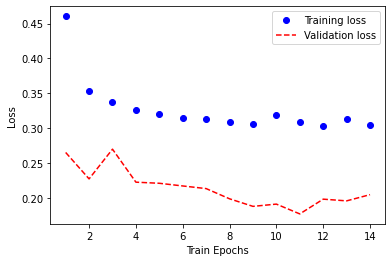

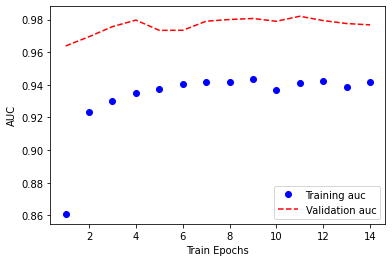

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

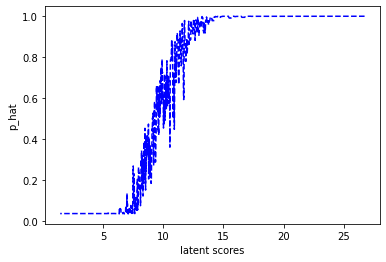

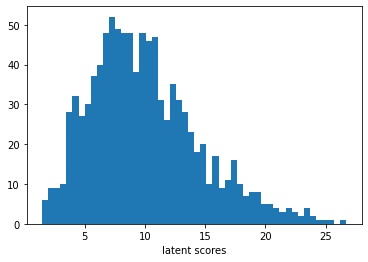

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

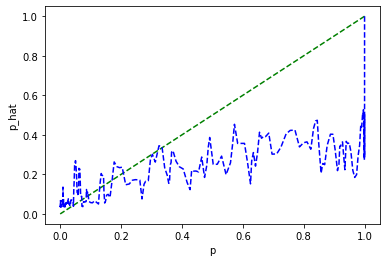

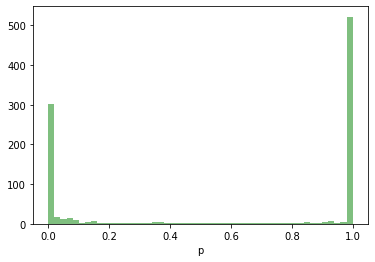

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

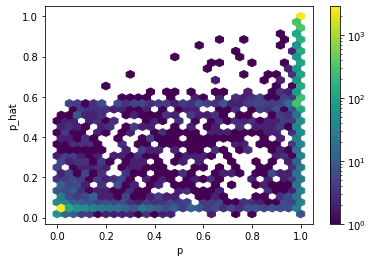

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

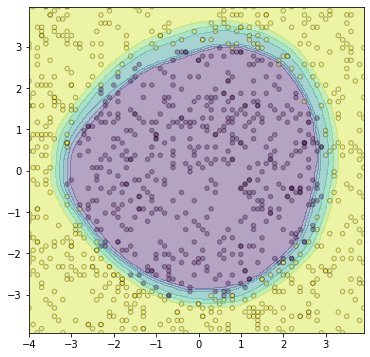

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.004,
 'batch': 8,
 'epoch': 10,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.18882715702056885, 'epoch': 14},
 'best_auc': {'auc': 0.9827141761779785, 'epoch': 14},
 'best_accuracy': {'accuracy': 0.9242500066757202, 'epoch': 7},
 'model': <keras.engine.sequential.Sequential at 0x7f7f702f4400>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.26700249314308167, 'epoch': 390},
  'best_auc': {'auc': 0.9873762130737305, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.8929499983787537, 'epoch': 249}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.26147130131721497, 'epoch': 277},
  'best_auc': {'auc': 0.9892704486846924, 'epoch': 393},
  'best_accuracy': {'accuracy': 0.9010999798774719, 'epoch': 150}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.24966801702976227, 'epoch': 238},
  'best_auc': {'auc': 0.9891086220741272, 'epoch': 385},
  'best_accuracy': {'accuracy': 0.9117000102996826, 'epoch': 140}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.22964699566364288, 'epoch': 820},
  'best_auc': {'auc': 0.9896509647369385, 'epoch': 793}

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25